In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from ase.io import read, write
from ase.neb import NEB
from ase.optimize import FIRE
from litraj.data import download_dataset, load_data
from litraj.metrics import get_metrics
from litraj.utils import get_barrier
from mace.calculators import mace_mp

In [4]:
download_dataset('nebDFT2k', '.')

Extracting: 100%|██████████| 3365/3365 [00:02<00:00, 1248.09it/s]


In [2]:
data = load_data('nebDFT2k', '.')

loading centroids: 100%|██████████| 1681/1681 [00:00<00:00, 2551.98it/s]


In [5]:
def optimize(images, submitdir, n_steps = 100, fmax = 0.1):
    
    # relaxe source
    qn_source = FIRE(images[0],
            logfile= f'{submitdir}/qn_source.log',
            trajectory= f'{submitdir}/qn_source.xyz',
            #restart = f'{submitdir}/qn_source.json',
            )
    qn_source.run()
        
    # relax target
    qn_target = FIRE(images[-1],
            logfile= f'{submitdir}/qn_target.log',
            trajectory= f'{submitdir}/qn_target.xyz',
            #restart = f'{submitdir}/qn_source.json',
            )
    qn_target.run(fmax = fmax, steps = n_steps)
    
    # optimize string
    neb = NEB(images,
                parallel=False,
                k = 5.0, 
                climb = True,
                method = 'improvedtangent'
                )
    
    qn = FIRE(neb,
            logfile=f'{submitdir}/qn.log',
            trajectory=f'{submitdir}/neb.xyz',
            #restart = submitdir + 'qn.json'
    )
    qn.run(steps = n_steps)
    return neb


In [ ]:
n_steps = 100
fmax = 0.1

# select device
device = 'cuda'

# path to save optimized trajectories
submitdir = 'uip_benchmark/mace_mp_small'
os.makedirs(submitdir, exist_ok=True)
for i, (images, edge_id) in enumerate(zip(data.trajectory_init, data.edge_id)):

    # skip if the optimized trajectory already exists
    if f'{edge_id}_relaxed_mace_mp_small.xyz' in os.listdir(submitdir):
        continue
        
    # set calculators
    images_copy = [image.copy() for image in images]
    for image in images_copy:
        image.calc = mace_mp(model="small", device=device, default_dtype="float64")
        
    # optimize string
    neb = optimize(images_copy, submitdir, n_steps = n_steps, fmax = fmax)

    # collect max forces
    max_neb_force = abs(neb.get_forces()).max()
    max_source_force = abs(neb.images[0].get_forces()).max()
    max_target_force = abs(neb.images[-1].get_forces()).max()

    # save only converged trajectories
    if max(max_neb_force, max_source_force, max_target_force ) < fmax:
        write(f'{submitdir}/{edge_id}_relaxed_mace_mp_small.xyz', neb.images, format = 'extxyz')

In [8]:
def collect_trajectories(folder, splitter = '_relaxed'):
    trajs = []
    edge_ids = []
    for file in tqdm(os.listdir(folder)):
        if 'xyz' in file:
            if 'relaxed' not in file:
                continue
            images = read(f'{folder}/{file}', index = ':')
            trajs.append(images)
            edge_id = file.split(splitter)[0]
            edge_ids.append(edge_id)
    return trajs, edge_ids

In [9]:
submitdir = 'uip_benchmark/mace_mp_small'
trajs, edge_ids = collect_trajectories(submitdir)

100%|██████████| 1441/1441 [00:26<00:00, 53.64it/s]


In [40]:
df = pd.DataFrame()
df['edge_id'] = edge_ids
df['trajectory_mace_mp_small'] = trajs
df = data[['edge_id', 'trajectory_relaxed', 'em_dft']].merge(df)

In [43]:
df['em_mace_mp_small'] = [get_barrier(traj_pred) for traj_pred in df.trajectory_mace_mp_small]

In [48]:
pd.DataFrame(get_metrics(df['em_dft'], df['em_mace_mp_small']), index = [0]).round(2)

,mae,rmse,Rp,slope,R2
0,0.16,0.32,0.92,0.95,0.82


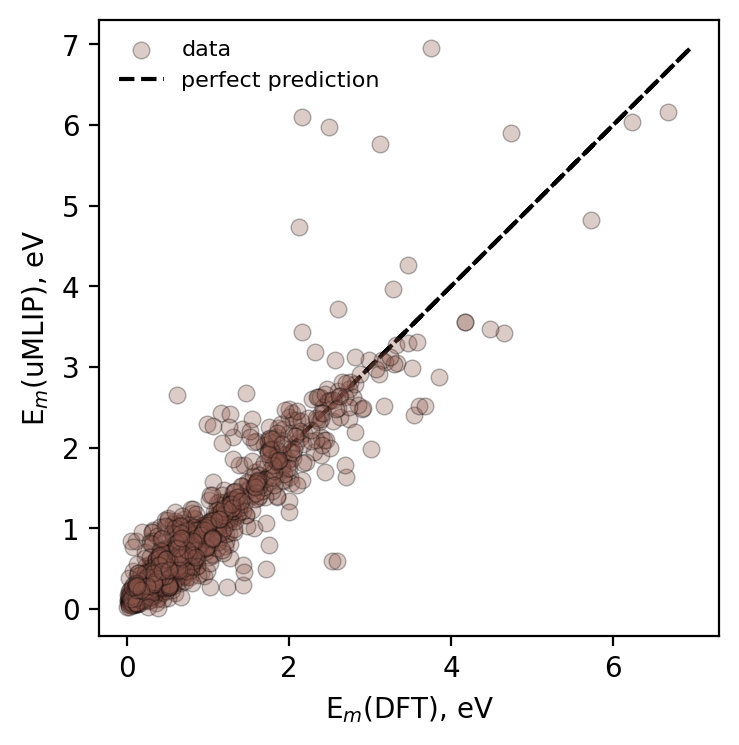

In [56]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(dpi = 200, figsize = (4, 4))
ax.scatter(df['em_dft'], df['em_mace_mp_small'],
           alpha = 0.3,
           color = 'C5',
           ec = 'k',
           linewidths=0.5,
           label = 'data',
           )
ax.plot(df['em_mace_mp_small'], df['em_mace_mp_small'],
         color = 'k',
         linestyle = '--',
         zorder = -1,
         label = 'perfect prediction'
         )
ax.set_xlabel('E$_m$(DFT), eV')
ax.set_ylabel('E$_m$(uMLIP), eV')
ax.legend(frameon = False, fontsize = 8)
